In [1]:
! pip install mlxtend==0.21.0
! pip install matplotlib==3.5.3

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from scipy import stats

Creating a visualization of classification will help you develop an intuition for classification. So next, you'll generate some random data, create a model using linear regression, and plot the result. For simplicity, you'll avoid real datasets for the time being. The scikit-learn library contains a datasets package that allows you to generate datasets with any properties that you wish to examine.

With the following code, use the datasets package to generate 200 samples with two classes. Then fit a linear regression model with the data. Next, use the mlxtend library to automatically plot the data points and the classification regions.

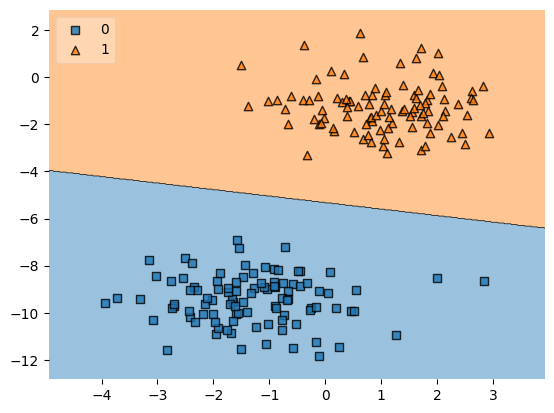

In [3]:
X, y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=1.0, random_state=2)

lr = LogisticRegression(solver='lbfgs', random_state=2)
lr.fit(X, y)

plot_decision_regions(X, y, clf=lr, legend=2)
plt.show()


In this plot, you can clearly see two regions. Any data point on the right of the boundary line will be classified into one class, and any data point on the left will be classified into the other class. You can see that this ideal dataset is properly classified into one class or the other. But in real life, you won't always, if ever, encounter such neat data. So make the data a little less neat by increasing the standard deviation of the clusters.

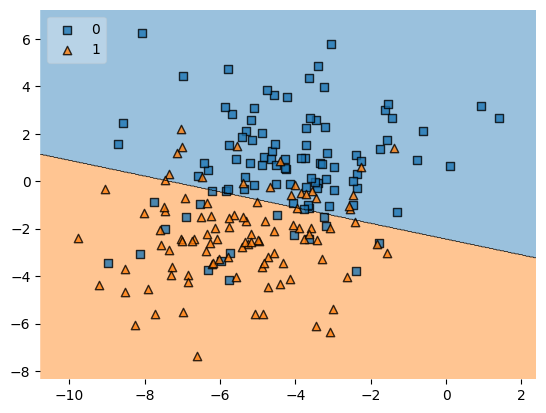

In [4]:
X, y = make_blobs(n_samples=200, centers=2, n_features=2, cluster_std=2.0, random_state = 225)

lr = LogisticRegression(solver='lbfgs', random_state=4)
lr.fit(X, y)

plot_decision_regions(X, y, clf=lr, legend=2)
plt.show()

This time, there are some data points that end up on the wrong side of the boundary line. There is no way to draw a single straight line to cleanly separate these two groups of data.

This example is illustrated using just two features, which makes it easy to plot on a two-dimensional screen and draw a simple line to show the boundary. With more features, the same thing happens, but in higher dimensions. For example, with three features, you can plot the points in three-dimensional space and separate the categories with a plane (imagine a flat sheet of paper). In higher dimensions, this becomes harder to visualize, but it follows the same mathematical process.

Based on this context, consider the following definitions:

 - **Classification algorithm:** Learn to predict categories from given features
 - **Decision boundary:** The surface separating different predicted classes
 - **Linear classifier:** The decision boundary is linear (a straight line)
 - **Linearly separable:** A dataset can be separated by a linear classifier

This last definition implies that not all datasets are suitable for linear classifications. Sometimes data may come in other forms that require different algorithms for classification.

In this lesson, you will take a deep dive into how a linear classifier works.

Consider the following subset of 50 samples from the *Breast cancer Wisconsin* dataset.

In [5]:
# Load the dataset
breast_cancer = load_breast_cancer()

# Select 50 samples and two features (for simplicity)
data_df = pd.DataFrame(breast_cancer.data[25:75], columns=breast_cancer.feature_names)
data_df = data_df[['mean radius', 'mean compactness']]
target_df = pd.DataFrame(breast_cancer.target[25:75])
target_df.columns = ['benign']

# Get the min and max on the x-axis for plotting lines later
minX = data_df['mean radius'].min()
maxX = data_df['mean radius'].max()

print(data_df.head())
print(target_df.head())

   mean radius  mean compactness
0        17.14            0.2276
1        14.58            0.1868
2        18.61            0.1066
3        15.30            0.1697
4        17.57            0.1157
   benign
0       0
1       0
2       0
3       0
4       0


You can plot these two features.

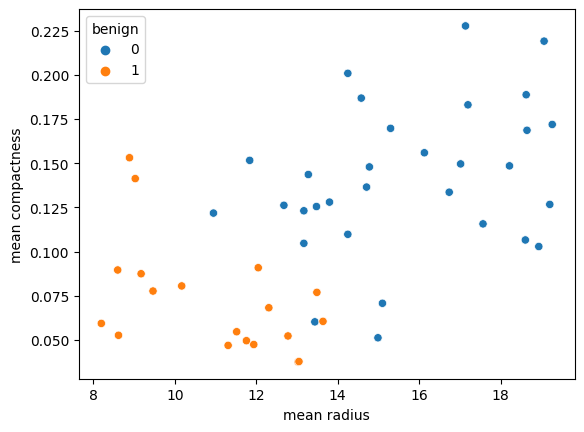

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x = 'mean radius', y = 'mean compactness', data = data_df, hue=target_df['benign'])
plt.show()


At a glance, you can see that as a tumor's radius increases, the chance of it being malignant increases. The process of classification is finding the line that will separate these two classes of data. You can start exploring this process by simply "guessing" a line. First, write a function that would plot a straight line given some parameters.

In [7]:
def drawLine(plt, m, c, min, max):
  x = np.linspace(min, max)
  y = m * x + c
  plt.plot(x, y, 'g-')

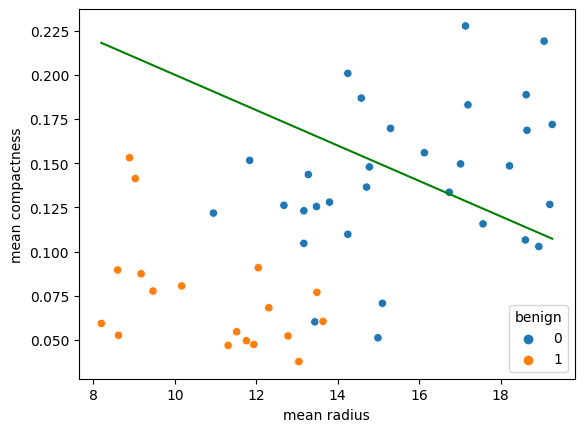

In [8]:
sns.scatterplot(x = 'mean radius', y = 'mean compactness', data = data_df, hue=target_df['benign'])
# Draw a line at some arbitrary place
drawLine(plt, -0.01, 0.3, minX, maxX)
plt.show()

This guess does not do a very good job at separating the space. So now, adjust the line slightly and see if that makes a difference.

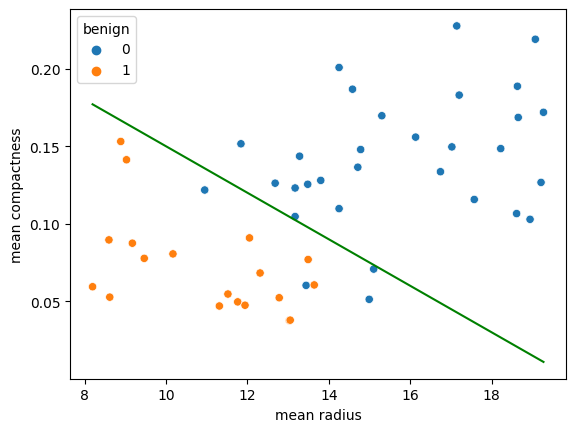

In [9]:
sns.scatterplot(x = 'mean radius', y = 'mean compactness', data = data_df, hue=target_df['benign'])
drawLine(plt, -0.015, 0.3, minX, maxX)
plt.show()

Just by eyeballing the plot, you can see that this is a little better. You can determine that it is better by looking at how many blue dots are on the wrong side of the line. In the first plot, there were 17 blue dots and 0 yellow dots on the wrong side of the line. After you adjusted the line, there were 4 blue dots and 0 yellow dots on the wrong side of the line. Because there are fewer errors with the second line placement, you can assume that it is a better boundary. You can keep adjusting slightly until you find the line that generates the fewest errors.

Now, try one more adjustment.

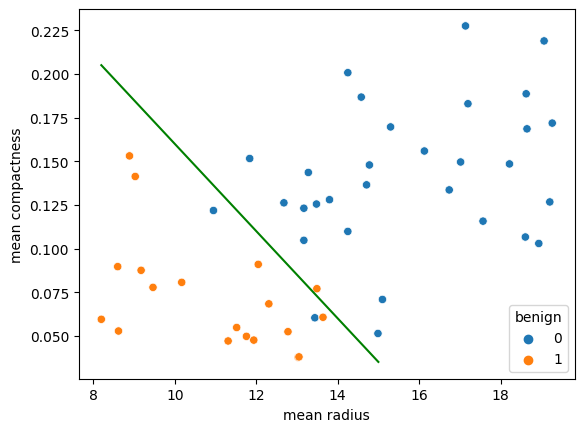

In [10]:
sns.scatterplot(x = 'mean radius', y = 'mean compactness', data = data_df, hue=target_df['benign'])
drawLine(plt, -0.025, 0.41, minX, 15)
plt.show()

This time, there are two blue dot errors and one yellow dot error, for a total of three errors. When you find the line that minimizes the error, you can stop.

## Equation of a line
Recall that the equation of a line is as follows:

$$ y = mx + c$$

Where $m$ is the slope or gradient and $c$ is the y-intercept.

You may have noticed that in the examples above, you have been manipulating the values for $m$ and $c$ to adjust the boundary line. These values are the *parameters* or *coefficients* that you search for in order to find a boundary that minimizes the error.

So, here's a summary of what's been covered so far:

1. This is a supervised learning problem. That means that you have labeled data to work with.
2. You are trying to find a linear decision boundary between two (or more) classes of data points.
3. There is some *error function*—a way to determine the accuracy of your decision boundary.
4. The whole process is about minimizing this error function.

## Hypothesis function
Now, take a look at why this algorithm is called *logistic regression*.

Say that you have a dataset of two features. Given these two features, you want to determine some relationship or pattern that maps these features onto a target or label. For example, given a mean radius and mean compactness of a tumor, you want to map those values to either a `1` (benign) or `0` (malignant). That is, you want to develop a function of the following form:

$$  y = f(x) $$

This function should predict $y$ given the input features $x$. However, you do not know the function $f(x)$ just yet. So you can refer to it as the *hypothesis function* and denote it as $h(x)$.

The hypothesis function takes the following form:

$$ h_{\theta}(x) = \theta_0 + \theta_1x_1 + \theta_2x_2$$

The values $\theta_0, \theta_1$, and $\theta_2$ are parameters (sometimes called *weights*) that you tune as you fit the function to the data. The values $x_1$ and $x_2$ are the features. Say, for example, that you have a feature that is strongly correlated with a label. The feature would have more weight or a larger theta ($\theta$) value compared to a feature that isn't a strong predictor.

Think of $\theta_0$ as some base value that determines if a tumor is malignant or not. This is sometimes called a *bias*. $\theta_1$ is the amount of contribution that the first feature—the mean radius in this case—contributes to the decision. And $\theta_2$ is the amount of contribution of the second feature to the decision. As you might imagine, this can be extended to any number of features, as follows:

$$ h_{\theta}(x) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \ldots + \theta_nx_n$$

For convenience, define the following vector:

$$\theta = \begin{bmatrix}\theta_0 \\ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n\end{bmatrix}$$

Also define the following vector:

$$ x = \begin{bmatrix}x_0 \\ x_{1} \\ x_{2} \\ \vdots \\ x_{n} \end{bmatrix} $$

So the hypothesis function may be concisely represented as follows:

$$ h_\theta(x) = \begin{bmatrix}\theta_0  & \theta_1 & \theta_2  & \ldots & \theta_n \end{bmatrix}\begin{bmatrix}x_0 \\ x_{1} \\ x_{2} \\ \vdots \\ x_{n} \end{bmatrix} = \theta^Tx$$

The symbol $\theta^T$ simply means "the transpose of $\theta$". That is, a column vector transposed becomes a row vector, and vice versa. Basic matrix multiplication would show that this concise form of the expression is the same as the original form.

You may have noticed that given $n$ features, you create a vector $x$ of $n+1$ elements. For convenience, assign the value `1` to $x_0$ for all rows of data in the dataset. This makes it easier to perform matrix multiplication between $\theta$ and $x$.




But, recall that you want $y$ to take on the values `0` or `1` and no other value. The hypothesis function as given will generate numbers outside of this range. This is where the *logistic* part of the logistic regression comes in. You take the hypothesis function and pass it through a *logistic function* (also called a *sigmoid function*).

### Logistic function
The logistic function takes the following form:

$$ g(z) = \frac{1}{1 + e^{-z}}$$

If plotted, this function looks like this:

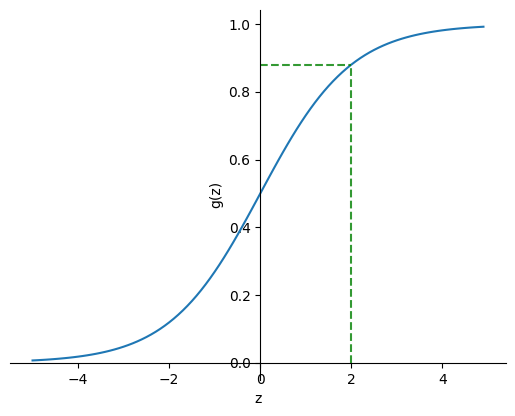

In [11]:
z = np.arange(-5, 5, 0.1)
g = 1 / (1 + np.exp(-z))

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position(('data', 0.0))
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.plot(z, g)
plt.plot([2, 2], [0, (1/(1 + np.exp(-2)))], 'g--', alpha = 0.8)
plt.plot([0, 2], [(1/(1 + np.exp(-2))), (1/(1 + np.exp(-2)))], 'g--', alpha = 0.8)
plt.xlabel('z')
plt.ylabel('g(z)')
plt.show()

This function is used to map any real number to the `(0, 1)` interval. That is, given any value $z$, plot it on the horizontal axis, and take a perpendicular up to the line. Then read the corresponding value of the vertical axis. For example, `2` on the horizontal axis maps to about `0.88` on the vertical axis.

So, given the function $g(z)$ as defined above, you can define the hypothesis function as follows:

$$ h_\theta(x) = g(\theta^Tx) $$

Where you set $z$ as follows: $$z= \theta^Tx $$

Now, you'll write up an implementation in Python. Instead of simply calling the `LogisticRegression` function from the scikit-learn package, you'll look into the details of how the sigmoid function actually works.

In [12]:
# `z` is a vector of real numbers
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def predict(features, weights):
  z = np.dot(features, weights)
  return sigmoid(z)



Because you are now guaranteed to get a value in the interval `(0, 1)`, you could further define the following:

$$ y = \begin{cases}1  & \text{ if } h_\theta(x) \ge 0.5 \\ 0 & \text{ if } h_\theta(x) \lt 0.5\end{cases} $$

## A worked example
Now, walk through a simple worked example. Suppose that you have the following data with two features.

Sample # |$x_1$ | $x_2$ | target
--- | --- | --- | ---
1 | 0.4 | 1.3 | 1
2 | 0.1 | 0.002 | 0

Running the algorithm generates the model defined by the following:

$$ \theta = \begin{bmatrix} 0.1 \\ -1.2 \\ 0.3 \end{bmatrix} $$

### For sample 1

$$ x_1 = \begin{bmatrix} 1 \\ 0.4 \\ 1.3 \end{bmatrix}$$

So performing $ z= \theta^Tx$ gives the following:

$$ \begin{align*}z & = \begin{bmatrix} 0.1 & -1.2 & 0.3 \end{bmatrix}\begin{bmatrix} 1 \\ 0.4 \\ 1.3 \end{bmatrix} \\ &= 0.1 \times 1 + -1.2 \times 0.4 + 0.3 \times 1.3 \\ &= 0.010\end{align*} $$

Then plotting this on the sigmoid function, you'll have the following:

$$ \begin{align*}g(0.010) & = \frac{1}{1 + e^{-0.010}} \\ &= 0.502 \end{align*}$$

Therefore:

$$ y = 1 \text{ because }  h_\theta(x_1) \ge 0.5 $$

### For sample 2

$$ x_2 = \begin{bmatrix} 1 \\ 0.1 \\ 0.002 \end{bmatrix}$$

So performing $z = \theta^Tx$ gives the following:

$$ \begin{align*}z & = \begin{bmatrix} 0.1 & -1.2 & 0.3 \end{bmatrix}\begin{bmatrix} 1 \\ 0.1 \\ 0.002 \end{bmatrix} \\ &= 0.1 \times 1 + -1.2 \times 0.1 + 1.3 \times 0.002 \\ &= -0.019\end{align*} $$

Then plot this on the sigmoid function as follows:

$$ \begin{align*}g(-0.019) & = \frac{1}{1 + e^{--0.019}} \\ &= 0.495 \end{align*}$$

Therefore:

$$ y = 0 \text{ because } h_\theta(x_2) \lt 0.5 $$


For the first sample, the model predicted `1`. For the second sample, the model predicted `0`.





In [13]:
x1 = [1, 0.4, 1.3]
theta = [0.1, -1.2, 0.3]
sample1 = predict(x1, theta)

print('For sample 1: ', sample1)

x2 = [1, 0.1, 0.002]
sample2 = predict(x2, theta)

print('For sample 2: ', sample2)

For sample 1:  0.502499979166875
For sample 2:  0.49515015210644203


## Cost function
Now that you've seen how you can use the hypothesis function to make some predictions, the next step is to measure the accuracy of the function. If the accuracy is too low, then adjust some parameters and measure the accuracy of the updated function. Repeat this process until you are satisfied with the accuracy or until you simply cannot get better accuracy.

In this section, you will examine the function that you'll use to measure the hypothesis function's accuracy. This is known as the *cost function* or *error function*.

For a given data sample, you can use the set of features $x$ to calculate the prediction given by your hypothesis function, as you did above, and compare it to the actual label for that sample $y$. If the prediction is different from the actual value of $y$, then you have an error. You then need to perform this for all samples in your training set, and sum the errors for a total error.

The objective of the algorithm is to minimize the error. The cost function used in logistic regression is defined as follows:

$$ cost(h_\theta(x), y) = \begin{cases} -log(h_\theta(x)) & \text{if} & y = 1 \\ -log(1 - h_\theta(x)) & \text{if} & y = 0\end{cases}$$

These two functions are plotted below.

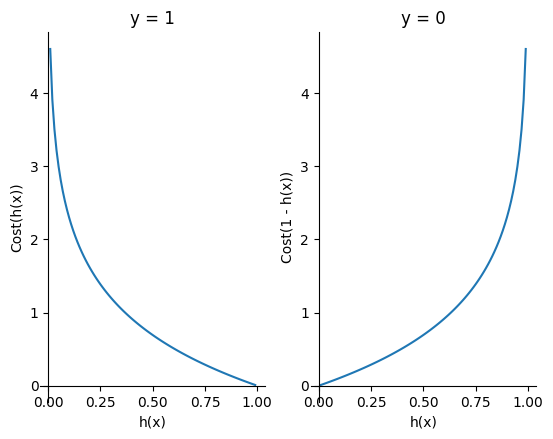

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
z = np.arange(0.01, 1, 0.01)
g = -np.log(z)
ax1.spines['left'].set_position(('data', 0.0))
ax1.spines['bottom'].set_position(('data', 0.0))
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.plot(z, g)
ax1.set(xlabel='h(x)', ylabel='Cost(h(x))')
ax1.set_title('y = 1')

g = -np.log(1 - z)
ax2.spines['left'].set_position(('data', 0.0))
ax2.spines['bottom'].set_position(('data', 0.0))
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.plot(z, g)
ax2.set(xlabel='h(x)', ylabel='Cost(1 - h(x))')
ax2.set_title('y = 0')

plt.show()

The left graph shows the function $-log(h_\theta(x))$. If $y = 1$ and the hypothesis function returns `1`, the penalty is `0`. But if the hypothesis function returns `0`, the penalty is very large. Similarly, the right side illustrates that if $y = 0$, then a prediction of `1` results in a large penalty, but a prediction of `0` has no penalty.

You can restate that cost function in a single line to make it easier to code.

$$ cost(h_\theta(x), y) = -ylog(h_\theta(x)) - (1 - y)log(1 - h_\theta(x))$$

In the cell below, this is illustrated in code.

In [15]:

def cost(pred, y):
  return -y * np.log(pred) - (1 - y) * np.log(1 - pred)

# Prediction is close to 0, y = 0 (small error)
y = 0
pred = 0.00001
print("y = 0, pred close to zero: ", cost(pred, y))

# Prediction is close to 1, y = 0 (large error)
pred = 0.99999
print("y = 0, pred close to one: ", cost(pred, y))

y = 1
pred = 0.00001
# Prediction is close to 0, y = 1 (large error)
print("y = 1, pred close to zero: ", cost(pred, y))

# Prediction is close to 1, y = 1 (small error)
pred = 0.99999
print("y = 1, pred close to one: ", cost(pred, y))



y = 0, pred close to zero:  1.0000050000287824e-05
y = 0, pred close to one:  11.51292546497478
y = 1, pred close to zero:  11.512925464970229
y = 1, pred close to one:  1.0000050000287824e-05


Now that you have an effective cost function, you could use it to calculate optimum parameters for the model. There are several algorithms that may be used here, and the most straightforward one to understand is called *gradient descent*.



## Gradient descent algorithm

Gradient descent is a fairly simple iterative algorithm. It involves repeatedly updating the parameters to the hypothesis function and measuring the error until the error is as small as possible.

To conceptualize this algorithm, imagine that you are standing on a mountain and you wish to walk to the lowest point in the landscape. For example, in the image below, you are the blue dot close to the highest point in the landscape.

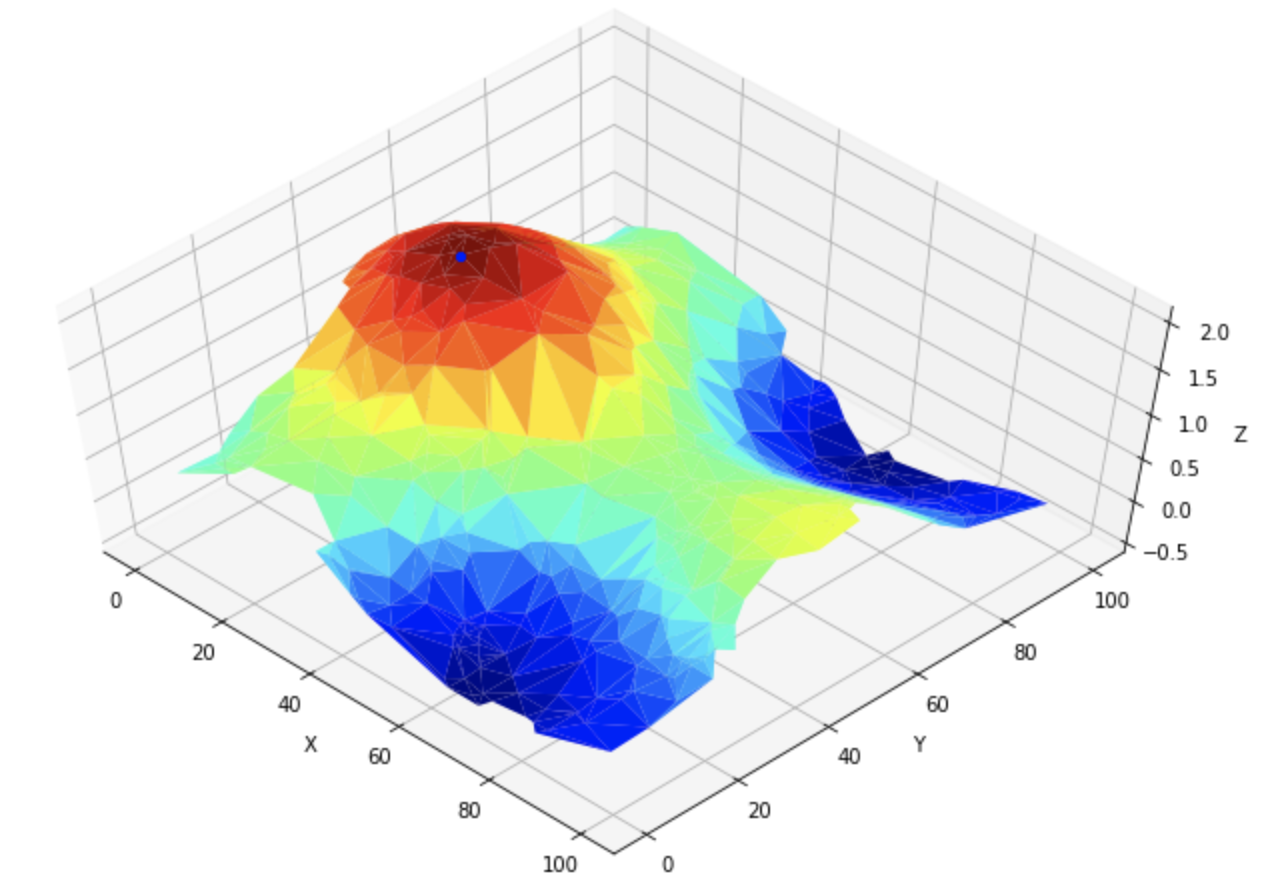

You look around in all directions and consider what would happen if you take a single step in each direction. In some directions, you will go higher up the mountain, in others, you will go lower down the mountain, and in still others, you will stay at roughly the same height. So you choose the step that takes you furthest downhill. Then you repeat that process, taking another step that takes you further downhill. Eventually, you get to a point where no step takes you further downhill. At that point, you are at the minimum point on the surface.

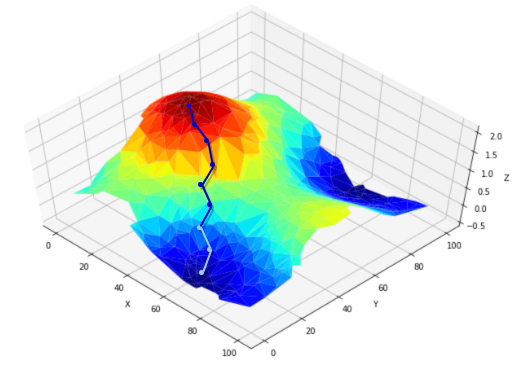

In this scenario, there are a number of things that you could vary to change the outcome. First, the size of step that you take may matter. If it is too large, then you risk overstepping the lowest point. If it is too small, then you have a better chance of reaching the lowest point. But with every small step, you have to recalculate the gradient, and that can be costly. In addition, that low point may not be considered the global minima (the lowest point). Instead, try to start off taking large steps, but gradually reduce the size of the step. The size of the step is called the *learning rate*.

Second, this visualization illustrates the cost function. The lowest point is the lowest cost. This is easier to see in two or three dimensions, but in most real-world scenarios, you will be working with high-dimensional data.

Below is a two-dimensional plot illustrating the same concept. The blue dot represents the current position, and the slope represents the error. The global minimum is the point where the slope is zero. In this example, gradient descent moves you downward toward the smaller slope.


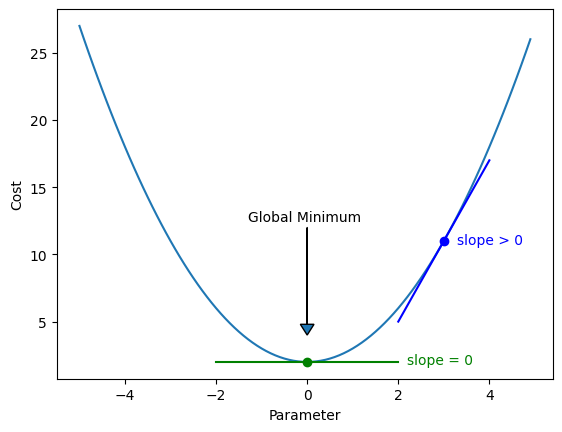

In [16]:
z = np.arange(-5, 5, 0.1)
g = z**2 + 2

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(z, g)
plt.plot([0], [2], 'og')
plt.plot([-2, 2], [2, 2], '-g')
plt.arrow(0, 12, 0, -8, length_includes_head=True, head_width=0.3, head_length=0.8)
plt.text(-1.3, 12.5, 'Global Minimum')

plt.text(2.2, 1.8, 'slope = 0', color='g')
plt.plot([3], [11], 'ob')
plt.plot([2, 4], [5, 17], '-b')
plt.text(3.3, 10.8, 'slope > 0', color='b' )
plt.xlabel('Parameter')
plt.ylabel('Cost')
plt.show()


Below is a full implementation of the algorithm as described so far. Some of the functions written above have been repeated for convenience. Note that this is a rather naive implementation designed to simply illustrate the process—so it should not be used in practice. The scikit-learn implementation is highly optimized for use in a wide variety of scenarios.

In [17]:
def cost(pred, y):
  return (-y * np.log(pred)) - ((1 - y) * np.log(1 - pred))

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def predict(features, weights):
  z = np.dot(features, weights)
  return sigmoid(z)

# This function is doing the main work of updating the weights in each iteration
def update_theta(features, weights, labels, learning_rate):
  M = len(features)
  predictions = predict(features, weights)
  gradient = np.dot(features.T, predictions - labels)
  gradient /= M   # Calculate gradient average
  gradient *= learning_rate # Multiply by learning rate
  weights -= gradient # Subtract from weights
  return weights


def train(features, labels, weights, learning_rate, iters):
    cost_history = []

    for i in range(iters):
        weights = update_theta(features, weights, labels, learning_rate)

        # Calculate error for auditing purposes
        pred = predict(features, weights)

        iter_cost = cost(pred, labels)
        cost_history.append(iter_cost.sum())

    return weights, cost_history

To try your own logistic regression classifier, load the *Breast cancer* dataset again.

In [31]:
# Load the dataset
breast_cancer = load_breast_cancer()

# Select 50 samples and 2 features (for simplicity)
data_df = pd.DataFrame(breast_cancer.data[25:75], columns=breast_cancer.feature_names)
data_df = data_df[['mean radius', 'mean compactness']]
data_df.insert(0, 'coef_1', 1)
target_df = pd.DataFrame(breast_cancer.target[25:75])
target_df.columns = ['benign']

initial_weights = [1.0, 1.0, 1.0]
learning_rate = 0.0005
MAX_ITER= 1000


weights, cost_history = train(data_df.values, target_df['benign'].values, initial_weights, learning_rate, MAX_ITER);

Again, select only a few rows and features because your implementation of the algorithm is not optimized. Starting with some arbitrary weights and an arbitrary learning rate, you'll iterate 1,000 times over the dataset, updating the coefficients (weights) each time by calculating the prediction error of the model. In the function, you are also keeping track of the cost so that you can see how it changes over time.

The code below plots the cost over time. Notice that the cost decreases on each iteration. Go ahead and test it out; examine the effect of increasing or decreasing the learning rate and the initial weights. Note, however, that because you implemented a very basic algorithm without proper error-checking, it is possible to input values that cause the program to run into an error.

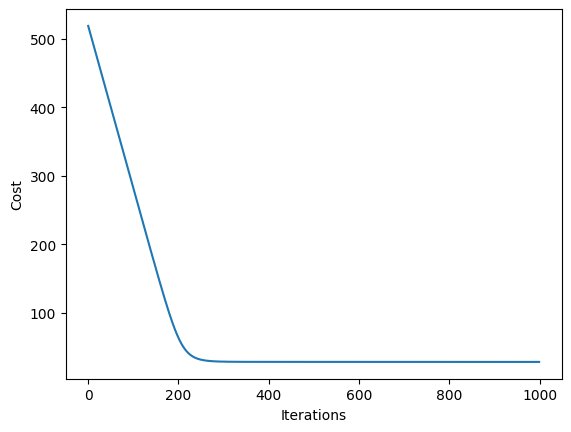

In [32]:
z = np.arange(0, MAX_ITER)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(z, cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

## Tuning logistic regression
Now that you have some insight into the way that this algorithm works, look at a few parameters that can be tuned in the scikit-learn library. First, you could load up the full *Breast cancer* dataset as a working example.

In [33]:
# Load the dataset
breast_cancer = load_breast_cancer()

data_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)

data_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Next, split the data into a training set and a test set, and train a logistic regression model on the training data. Scikit-learn's defaults provide certain optimizations. So here, deliberately start with no tuning by turning off some of those optimizations.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data_df, breast_cancer.target, random_state=2)

# lr = LogisticRegression(solver='lbfgs', penalty='none', random_state=2)
lr = LogisticRegression(solver='lbfgs', random_state=2)
lr.fit(X_train, y_train)

print('accuracy score: %s' % lr.score(X_test, y_test))
print('# of iterations %s' % lr.n_iter_[0])


accuracy score: 0.9370629370629371
# of iterations 100


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


By default, the maximum number of iterations is set to `100`. Try increasing that to see if you get better results.

In [35]:
# lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=1000, random_state=2)
lr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=2)
lr.fit(X_train, y_train)

print('accuracy score: %s' % lr.score(X_test, y_test))
print('# of iterations %s' % lr.n_iter_[0])


accuracy score: 0.9440559440559441
# of iterations 1000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The algorithm still failed to converge after 1,000 iterations (as you can see by the output of n_iter_ reaching the max number of iterations). Try increasing it one more time.

In [36]:
# lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=10000, random_state=2)
lr = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=2)
lr.fit(X_train, y_train)

print('accuracy score: %s' % lr.score(X_test, y_test))
print('# of iterations %s' % lr.n_iter_[0])


accuracy score: 0.9370629370629371
# of iterations 1698


It seems that even after increasing the number of iterations, it's finally converging, but the accuracy score has not improved. Now, examine the effect of that penalty parameter.

## Regularization
Overfitting occurs when the model becomes too specific to the training data and does not generalize to previously unseen data. You can test for overfitting by comparing how well the model scores on the training data itself versus the test data. In the following code, you'll train a model and then test it on both the training data and the test data.

In [42]:
lr = LogisticRegression(solver='lbfgs', penalty='none', max_iter=10000, random_state=2)
# lr = LogisticRegression(solver='lbfgs', max_iter=10000, random_state=2)
lr.fit(X_train, y_train)

test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Score on training data:  0.9929577464788732
Score on test data:  0.9300699300699301


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Above, you can see that the training data scored better than the test data. This may indicate that some overfitting is happening. One way to combat overfitting is to use regularization. Regularization has the effect of reducing the variance between coefficients. This means that the model does not fit the training data quite as well, but it should generalize to unseen data better.

There are several regularization options available. Two popular types are named *L1* and *L2*, and both are available in scikit-learn. By default, the `lbfgs` solver uses L2 regularization. But for demonstration purposes, explicitly specify the L2 with the `penalty` parameter. L2 regularization modifies the cost function such that a larger penalty is imposed on larger coefficients, making the algorithm biased toward smaller coefficients.

In [43]:
lr_regularized = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=10000, random_state=2)
lr_regularized.fit(X_train, y_train)

test_score = lr_regularized.score(X_test, y_test)
train_score = lr_regularized.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.9647887323943662
Score on test data:  0.9370629370629371


First, notice that with regularization turned on, the algorithm converged to a minimum. Also, notice that the score on the training data reduced by a little, indicating that less overfitting is happening. To understand the effect of regularization, plot the final coefficients generated using no regularization and using L2 regularization. As mentioned above, regularization reduces the variance, effectively smoothing out the decision boundary and making the resulting model generalize to unseen data better.

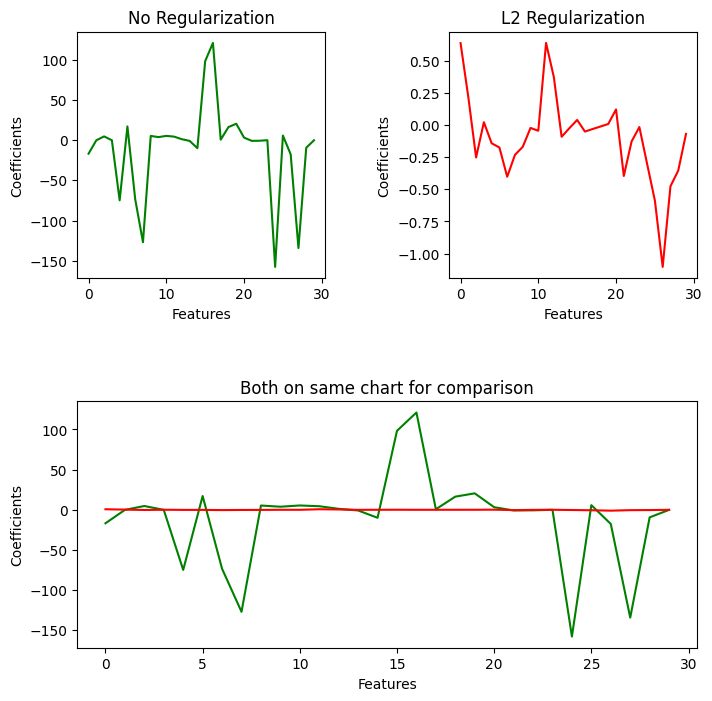

In [44]:
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.5)

x = np.arange(0, len(lr.coef_[0]),1)
y = lr.coef_[0]
ax1 = fig.add_subplot(grid[0, 0])
ax1.plot(x, y, '-g')
ax1.set(xlabel='Features', ylabel='Coefficients')
ax1.set_title('No Regularization')

y_reg = lr_regularized.coef_[0]
ax2 = fig.add_subplot(grid[0, 1])
ax2.plot(x, y_reg, '-r')
ax2.set(xlabel='Features', ylabel='Coefficients')
ax2.set_title('L2 Regularization')

ax3 = fig.add_subplot(grid[1, 0:])
ax3.plot(x, y, '-g')
ax3.plot(x, y_reg, '-r')

ax3.set(xlabel='Features', ylabel='Coefficients')
ax3.set_title('Both on same chart for comparison')
plt.show()

With no regularization, you can see that the coefficient values range from `-150` to `120`. With regularization, the values range from `-1` to `1`. In addition to just choosing the regularization algorithm, you can tune how it works by adjusting the parameter $C$. $C$ is an inverse regularization strength parameter, meaning that lower values of $C$ cause stronger regularization.

Choosing an appropriate value of $C$ can be tricky. It may be necessary to try various values and pick the one that minimizes the difference between training accuracy and test accuracy. In the following code, you'll create many logistic regression models with different values of $C$ and plot the training and test accuracy.

**Note:** The following code may take some time to execute because it is running the logistic regression algorithm several times. If it causes a problem, you can try selecting a subset of the data and running this code with less data.

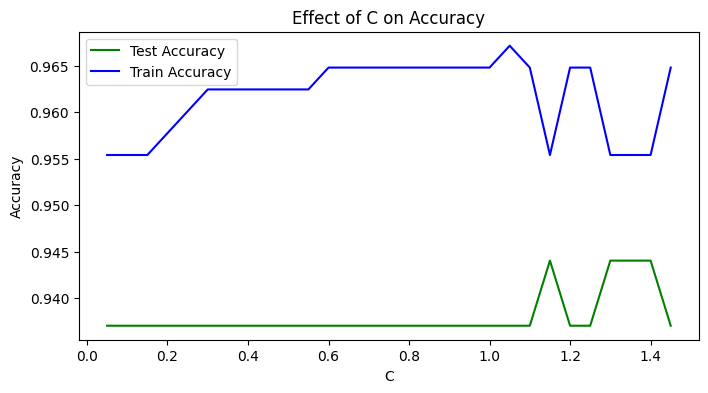

In [45]:
c_vals = np.arange(0.05, 1.5, 0.05)
test_accuracy = []
train_accuracy = []

for c in c_vals:
  lr = LogisticRegression(solver='lbfgs', penalty='l2', C=c, max_iter=10000, random_state=2)
  lr.fit(X_train, y_train)
  test_accuracy.append(lr.score(X_test, y_test))
  train_accuracy.append(lr.score(X_train, y_train))

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(c_vals, test_accuracy, '-g', label='Test Accuracy')
ax1.plot(c_vals, train_accuracy, '-b', label='Train Accuracy')
ax1.set(xlabel='C', ylabel='Accuracy')
ax1.set_title('Effect of C on Accuracy')
ax1.legend()
plt.show()

You can see that you get the best test accuracy somewhere between `1.2` and `1.4`. The minimum distance between training and test accuracy in this range seem to occur around the `1.3` mark. For this example, `1.3` might be the best choice for $C$.

## Choosing a solver
In the example above, you used the [lbfgs](https://en.wikipedia.org/wiki/Limited-memory_BFGS) solver. You don't need to get into all the details of how this algorithm works, but you can think of it as a more complex variation of the gradient descent algorithm. Scikit-learn will choose this as its default solver from version 0.22 onward. It is good for small datasets, but as you saw above, it may fail to converge.

For larger datasets, the SAG or SAGA solvers are better choices. It may be useful at this point to simply try the various solvers and compare their results. Here's how the scikit-learn documentation summarizes them:

> Algorithm to use in the optimization problem.
>
>   For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
>   For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;   
>  ‘liblinear’ is limited to one-versus-rest schemes.
>  ‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty
>  ‘liblinear’ and ‘saga’ also handle L1 penalty
>  ‘saga’ also supports ‘elasticnet' penalty
>  ‘liblinear’ does not handle no penalty
>
> Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

## Scaling
One final optimization is scaling the features so that they are approximately the same scale. Some solvers are affected by this. Scikit-learn has several different built-in scalers. Now, examine the effect of scaling on the model that you worked with above. First, look at a summary of the variance in each feature of the data.

In [46]:
data_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


You can see that each feature is on a different scale. For example, the mean radius ranges from `6.98` to `28.11`, while the mean area ranges from `654` to `2501`. Below, use the standard scaler to scale these features.

In [47]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_df)
data_df_scaled = pd.DataFrame(scaled_data, columns=breast_cancer.feature_names)
data_df_scaled.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,...,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02,5.690000e+02
mean,-3.153111e-15,-6.568462e-15,-6.993039e-16,-8.553985e-16,6.081447e-15,-1.136369e-15,-2.997017e-16,1.023981e-15,-1.860648e-15,-1.504752e-15,...,-2.297713e-15,1.742016e-15,-1.198807e-15,6.118909e-16,-5.094929e-15,-2.122887e-15,6.118909e-16,-1.998011e-16,-2.422589e-15,2.497514e-15
std,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,...,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00,1.000880e+00
min,-2.029648e+00,-2.229249e+00,-1.984504e+00,-1.454443e+00,-3.112085e+00,-1.610136e+00,-1.114873e+00,-1.261820e+00,-2.744117e+00,-1.819865e+00,...,-1.726901e+00,-2.223994e+00,-1.693361e+00,-1.222423e+00,-2.682695e+00,-1.443878e+00,-1.305831e+00,-1.745063e+00,-2.160960e+00,-1.601839e+00
25%,-6.893853e-01,-7.259631e-01,-6.919555e-01,-6.671955e-01,-7.109628e-01,-7.470860e-01,-7.437479e-01,-7.379438e-01,-7.032397e-01,-7.226392e-01,...,-6.749213e-01,-7.486293e-01,-6.895783e-01,-6.421359e-01,-6.912304e-01,-6.810833e-01,-7.565142e-01,-7.563999e-01,-6.418637e-01,-6.919118e-01
50%,-2.150816e-01,-1.046362e-01,-2.359800e-01,-2.951869e-01,-3.489108e-02,-2.219405e-01,-3.422399e-01,-3.977212e-01,-7.162650e-02,-1.782793e-01,...,-2.690395e-01,-4.351564e-02,-2.859802e-01,-3.411812e-01,-4.684277e-02,-2.695009e-01,-2.182321e-01,-2.234689e-01,-1.274095e-01,-2.164441e-01
75%,4.693926e-01,5.841756e-01,4.996769e-01,3.635073e-01,6.361990e-01,4.938569e-01,5.260619e-01,6.469351e-01,5.307792e-01,4.709834e-01,...,5.220158e-01,6.583411e-01,5.402790e-01,3.575891e-01,5.975448e-01,5.396688e-01,5.311411e-01,7.125100e-01,4.501382e-01,4.507624e-01
max,3.971288e+00,4.651889e+00,3.976130e+00,5.250529e+00,4.770911e+00,4.568425e+00,4.243589e+00,3.927930e+00,4.484751e+00,4.910919e+00,...,4.094189e+00,3.885905e+00,4.287337e+00,5.930172e+00,3.955374e+00,5.112877e+00,4.700669e+00,2.685877e+00,6.046041e+00,6.846856e+00


Now each feature is on roughly the same scale. Use this scaled dataset to train the logistic regression model and compare it to the results that you got from above.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data_df_scaled, breast_cancer.target, random_state=2)
lr = LogisticRegression(solver='lbfgs', max_iter=10000, penalty='l2', C=0.6, random_state=2)
lr.fit(X_train, y_train)

test_score = lr.score(X_test, y_test)
train_score = lr.score(X_train, y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.9859154929577465
Score on test data:  0.9790209790209791


That's a very significant increase in test accuracy! A careful comparison of the various solvers, regularization values, and scaling will usually reveal the best combination for the best results.